In [3]:
# The usual imports as always
import numpy as np 
import h5py 
import matplotlib.pyplot as plt
import scipy.stats
import astropy.units as u
from dataclasses import dataclass
from scipy.interpolate import interp1d
from tqdm import trange

# Premade package for MCMC
import emcee

## The Gaussian likelihood function
We will assume that the individial datapoints, $x_i$, are uncorrelated, and the Gaussian probability distribution can then be written as:
$$p(x;\mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right]$$
We have $N$ datapoints $x_i$, and we want to fit a model to it. The model will predict some value $\mu_i$ for each datapoint, and there is some known uncertainty $\sigma_i$ to each datapoint. The joint likelihood for all datapoints $x_i$ given these predicted values $\mu_i$ are
$$\mathcal{L} = \prod_{i=1}^N p(x_i;\mu_i,\sigma_i).$$

**Task:** Write out this likelihood.

## The Gaussian log-likelihood function
We want to solve for the $\mu$'s which maximise the likelihood $\mathcal{L}$. A neat trick is that the maximum of $\ln{\mathcal{L}}$ is also the maximum of $\mathcal{L}$, and the former is much easier to solve.

**Task (hint: this can be answered in one single sentence :^D):** Why is solving for $\mathrm{max}_\mu(\mathcal{L})$ equivalent to solving for $\mathrm{max}_\mu(\ln\mathcal{L})$?

**Task:** Derive $\ln\mathcal{L}$.

**Task:** Write a function which returns $\ln\mathcal{L}$ given three vectors $x_i$, $\mu_i$, and $\sigma_i$, all of length $N$.

### What do we do about $\sigma_i$?
Estimating $\sigma_i$ in the power spectrum domain can be somewhat difficult, and we will simply define the experimental uncertainty as `P_rms = 100.0` across all $k$-bins (in units of $[\mu K^2 Mpc^{3}]$).

**Task:** Can you think of any other sources of uncertainty apart from the usual experimental noise? List a couple and discuss where they come from and how they affect the uncertainty.

In [4]:
# TODO
def log_likelihood(x, mu, sigma):
    raise NotImplementedError()

# Solution
def log_likelihood(x, mu, sigma):
    return - 0.5 * np.sum((x - mu)**2/sigma**2)

## Our first model
We will now introduce a simple one-parameter model to try and describe our power spectrum. In this model, we will assume that the CO power spectrum is proportional to the dark matter power spectrum of our universe, $P_m(k)$. We name the scaling factor $A_\mathrm{clust}$, since this term dominates in the low-$k$ clustering region (as opposed to the high-$k$ shot noise region, which we will introduce later). Our data model is now simply
$$P(k) = A_\mathrm{clust}P_m(k),$$
where we will fit for the unknown scalar $A_\mathrm{clust}$, and $P_m(k)$ is a function we will simply read from a file and interpolate:

In [6]:
l = np.load('20240204_redux.npz')
Pm_func = interp1d(l['k'], l['Pm'], fill_value='extrapolate')  # "Pm_func" is now a callable function, which takes a single argument, k.

def PS_model_1(k, A_clust):
    return A_clust*Pm_func(k)

Let's read our power spectrum data from part 1 from file, and have a quick look at how the model compares:

**Task**: Replace this data with our own power spectrum.

In [5]:
k = np.load("../data/k.npy")
PS = np.load("../data/PS_cross.npy")
PS_rms = 100.0*np.ones_like(PS)

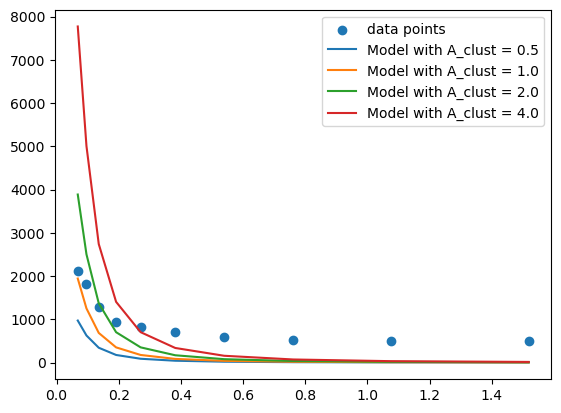

In [7]:
plt.scatter(k, PS, label="data points")
for A_clust in [0.5, 1.0, 2.0, 4.0]:
    plt.plot(k, PS_model_1(k, A_clust), label=f"Model with A_clust = {A_clust}")
plt.legend()

As we can see, it's not a great model for our data, but let's find what $A_\mathrm{clust}$ gives the maximum likelihood result!

## Brute-force plotting the likelihood
Before using a proper sampler to explore the likelihood, we will simply brute-force it, since we're working on such a simple dataset.

**Task:** Define an array of $A_\mathrm{clust}$ values, and calculate the log-likelihood for these.

In [8]:
A_clust_range = np.linspace(0, 10, 401)

# TODO ...


100%|██████████| 401/401 [00:00<00:00, 33900.03it/s]


**Task:** Plot the model you found together with the data-points. Also plot the *residual* (the data minus the model) in a separate plot.

## A better model
We will now drastically improve our model by adding a second parameter to it. This paramter is called $P_\mathrm{shot}$, and is simply a $k$-independent scalar which offsets the entire power spectrum:
$$P(k) = A_\mathrm{clust}P_m(k) + P_\mathrm{shot}$$

In [11]:
def PS_model_2(k, A_clust, P_shot):
    return A_clust*Pm_func(k) + P_shot

**Task:** Repeat the process above, but now define a 2D grid of values for both P_shot and A_clust, and calculate the log-likelihood for these. Visualize the likelihood as a 2D color plot (plt.pcolormesh or plt.imshow).

**Task:** Plot both the old and new best-fit models together with the data.

## Sampling the likelihood
### Context
Now let's move over to sampling the likelihood. As you might have noticed, it worked fine to simply brute-force solve the entire likelihood. However, more often than not, the number of parameter we want to optimize over is so large that this is unfeasible. With a 7-parameter model, if we wanted to calculate the likelihood on a grid with 300 points along each axis, we would have to evaluate the likelihood $300^7 \approx 10^{16}$ times. Completely unfeasible.

It's also important to distinguish between *samplers* and *optimizers*. An optimizer is simply trying to find the maximum (or minimum) of some function, which is useful for a ton of applications, like training machine learning algorithms. However, we don't just want to know where the peak of the likelihood is, we also want to know what the likelihood looks like in a sizeable region around the peak, so that we can get a full picture of correlations between variables, non-gaussian errors, etc. For this, we use a sampler.

### The emcee sampler
We suggest you use the Python-package `emcee`(https://emcee.readthedocs.io/en/stable/tutorials/quickstart/) as your MCMC sampler. This is a smart and advanced sampler, which you don't need to understand the details of, but from the outside it looks like any other simple sampler, like the Metropolis-Hastings. You give it some (log) likelihood you want to explore, and it gives you back a chain of samples. If you sample for long enough, those samples will closely trace the real likelihood. The only thing to be aware of is that is uses multiple walkers, so you will get multiple independent chains.

The only thing you need to provide `emcee` with is a function for calculating the log-likelihood, given some guess at the parameters (A_clust and P_shot). The function expects only a single argument for the parameters, so you will need to unpack them inside the function.

**Task:** Implement the log-likelihood function outlined below. Run the emcee sampler on the likelihood. If you want to, you can start with the 1D case of model1, but you can also skip it if you want to.

**Task:** Plot the chain values (i.e. MCMC samples) as a function of steps, and see if they appear to converge around reasonable values. This is easiest to see if you pick out a single walker chain. Is there a burn-in period (and what is this)? How long is it?

**Task:** Scatter-plot the chain values on top of the 2D plot of the likelihood (which you brute-forced). Does the samples appear to trace this distribution well?

**Task:** Calculate the $A_\mathrm{clust}$ and $P_\mathrm{shot}$ values preferred by the `emcee` results. How can you do this?

In [1]:
# TODO
def log_likelihood_model2(x, mu, rms):
    return NotImplemented



## Model selection
We end with some simple model selection comparison between the two models we have defined. Model selection revolves around chosing which of two (or more) models best fit the data, taking into account how many parameters go into each model. A model with more parameters is expected to have a smaller residual (e.g. a third order polynomial will always fit any data better than a second order polynomial). In our case, model 1 has only 1 parameter, while model 2 has 2 parameters. We know that model 2 fits the data better, but we will now decide whether the improvement is large enough to justify the additional free parameter.

You will implement two simple ways of model selection. The Akaie Information Criterion (AIC), and the Bayesian Information Criterion (BIC). They are both pretty similar, and both revolve around comparing the maximum likelihood of both models (specifically, $-2\ln(\mathcal{L^0})$), but adding a penality for the number of parameters used, $k$. Note that the value $\mathcal{L^0}$ means the maximum value of the likelihood, for the optimal parameters for that model.

**Task:** Implement AIC and BIC, and compare the values you get from model 1 and model 2. Does the additional parameter of model 2 increase or decrease the AIC and BIC?

Tip: You can, as usual, ignore the constant term in the log-likelihood, as we are comparing two likelihoods, and the constant will be the same for both likelihoods.

In [47]:
def AIC(logL, k, N):
    return NotImplemented

def BIC(logL, k, N):
    return NotImplemented

**This is the end of project part 2. Well done!**